# Comparisson with Conv1D-LSTM Networks - Bearing Dataset


## Imports

In [1]:
from collections import OrderedDict

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True

# for no GPU:
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd
from datasets.femto_bearing import FEMTOBearingsDataset

not running in colab.


In [2]:
data_root= '/mnt/6c99ccdb-4d5e-443d-b361-8b5137623ef6/'
rootfolder_pickles='%s/Dataset/bearing_fatigue_dataset/'%data_root
npz_file='%s/Dataset/bearing_fatigue_dataset/first_stage_preproc_bearings_v2.npz'%data_root
femto_dataset = FEMTOBearingsDataset(rootfolder_pickles=rootfolder_pickles, npz_file=npz_file)

training set:
00 1 1_1 2803
03 1 1_4 1428
04 1 1_5 2463
05 1 1_6 2448
06 1 1_7 2259
07 2 2_1 911
09 2 2_3 1955
11 2 2_5 2311
15 3 3_2 1637

testing set:
16 3 3_3 434
02 1 1_3 2375


In [3]:
learning_set = ['1_2','1_3','1_4','1_5','2_1','2_5','2_6','3_3'] # Giving decent results.
learning_set = ['1_2','1_3','1_4','1_5','2_1','2_5','2_6','3_3','1_7'] # Giving decent results. 
learning_set = ['1_2','1_3','1_4','1_5','2_1','2_5','2_6','3_3'] # Paper
#learning_set = ['1_3','1_2','1_4','1_5','2_1','2_5','3_2','3_3'] # Giving decent results.
# learning_set = ['1_3','1_2','1_4','1_5','1_7','2_1','2_5','2_6','3_3'] # Giving decent results.
# learning_set = ['1_3','1_2','1_4','1_5',      '2_1','2_5','2_6','3_3'] # Giving decent results.
# learning_set = ['1_3','1_2','1_4','1_5','2_2','2_1','2_5','2_6','3_3'] # Giving decent results.
#learning_set = ['1_3','1_1','1_4','1_5','2_3','2_5','3_3'] # Giving decent results.

#learning_set.extend([femto_dataset.file_suffix[k_] for k_ in [3,4,5,,10]])
print(learning_set)
learning_set_inds = [femto_dataset.file_suffix.index(k) for k in learning_set]
eval_inds = [f for f in femto_dataset.file_suffix if f not in learning_set]

val_set_inds = [femto_dataset.file_suffix.index(k) for k in eval_inds]
APPLY_DEFAULT_SETUP = True
if APPLY_DEFAULT_SETUP:
    femto_dataset.inds_exp_source = learning_set_inds
    femto_dataset.inds_exp_target = val_set_inds


['1_2', '1_3', '1_4', '1_5', '2_1', '2_5', '2_6', '3_3']


# Load data

In [4]:
if False:

    import os
    all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

    load_from_disk = False;
    load_first_stage = True
    if load_from_disk:
        def load_bearings_dataset(all_files = all_files):
            fnames = all_files
            exp_ids_tot = [];
            yrem_tot = [];
            sensor_values_tot = []

            for kk,fname in enumerate(fnames):
                p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
                p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6

                sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
                sens_val = np.dstack([v[1] for v in sensors.values])
                sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
                print(sensor_values.shape)

                yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
                yrem = np.abs(yrem - np.max(yrem))

                exp_id = np.hstack([kk for v in range(yrem.shape[0])])

                sensor_values_tot.append(sensor_values)
                exp_ids_tot.append(exp_id);
                yrem_tot.append(yrem)

                print(kk)

            yrem_tot = np.vstack(yrem_tot).flatten()
            eid = np.hstack(exp_ids_tot).flatten()
            X__ = np.vstack(sensor_values_tot)
            return yrem_tot, eid, X__
        yrem_s_raw, eid, X = load_bearings_dataset()

    if load_first_stage:
        L = np.load("first_stage_preproc_bearings.npz")
        yrem_s_raw, X, eid = [L[l] for l in L.files]
        
        
    
    normalization_factor_time = 25000;
    yrem_norm = yrem_s_raw/normalization_factor_time;

    yrem_norm[yrem_norm<0.0001] = 0.0001

    eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
    for k in np.unique(eid):
        eid_oh[eid == k,k] = 1.;

    #yrem_norm = yrem / np.std(yrem);

    #training_set_mask = 
    conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
    inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

    conds_flag_target = [0,0,0,   1, 1, 1,  2]
    inds_exp_target  = [1,5,16,  12,13,14,  3]


    conds_flag = [*conds_flag_source, *conds_flag_target]
    inds_experiments = [*inds_exp_source, *inds_exp_target]
    exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

    loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
    loading_oh = np.zeros([eid_oh.shape[0],3])
    for k in np.unique(loading_cond):
        loading_oh[loading_cond == k,k] = 1;


    # conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
    # inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

    # conds_flag_target = [0,0,0,   1,  2]
    # inds_exp_target  = [1,5,16,  12,  3]



    inds_experiments = [*inds_exp_source, *inds_exp_target]

    #############################################################
    #Remove unused experiments:

    ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]


    X.shape,eid_oh.shape
    #inds_exp_source
    min_samples_keep = 1000;

    exp_and_counts = [(kk,np.sum(eid_oh[:,kk] == 1)) for kk in range(len(inds_exp_source))]
    inds_exp_source_new = [];
    for e,i in exp_and_counts:
        if i>min_samples_keep:
            inds_exp_source_new.append(e)
    #inds_exp_source
    print(exp_and_counts)
    inds_exp_source = inds_exp_source_new
    #inds_exp_source = [2]
    print(inds_exp_source)

In **GraphNets** I cannot simply randomly sample from different experiments. I need some code to make graph inputs for this dataset.

In [5]:
from utils import get_graph_data
if False:

    from fictitious_example.dataset_utils import *
    from fictitious_example.minigraphnets import * 
    def data_from_experiment(eid, X_ = None, eid_oh_ = None, yrem_norm_ = None):
        ids = (np.argmax(eid_oh_,1) == eid)
        Xexp = X_[ids,:,:];
        yrem_exp_ = yrem_norm_[ids];
        return Xexp, yrem_exp_


    def get_indices(ngraphs, ntotal_inds,n_seq_nodes, spacing_ratio = 0.5,
                    nnode_range = None,nmax_node_range = 20, fixed_spacing_indices = None):
        """
        A function to sample increasting random indices from index sets.

        ngraphs         : how many index sets to sample

        ntotal_inds     : the indices of the series. 

        n_seq_nodes     : how many nodes should there be per index set sample

        spacing_ratio   : this controls how close or far away are the nodes sampled. The larger 
                          it is the further away the nodes are. Smaller than 1.

        nnode_range     : (None) Alternatively from the `spacing_ratio` one can define the actual 
                          number of samples that are skipped.

        nmax_node_range : ...


        """

        if nmax_node_range is None:
            nmax_node_range = int(np.floor(ntotal_inds*spacing_ratio));

        if nnode_range is None:
            nnode_range = int(np.floor(nmax_node_range/n_seq_nodes));

        first_node_range = ntotal_inds - nmax_node_range;
        indices = [];

        n = np.random.choice(first_node_range,ngraphs);

        indices.append(n)
        for node_idx in range(n_seq_nodes-1):
            if fixed_spacing_indices is None:
                new_idx_shift = np.random.choice(nnode_range, ngraphs);
            else:
                new_idx_shift = fixed_spacing_indices

            indices.append(indices[-1] + new_idx_shift)

        indices = np.vstack(indices)
        return indices.T

    def get_graph_data(experiment,  X_ = None, eid_oh_ = None, yrem_norm_ = None, 
                       n_sampled_graphs = 100, nnodes = 3, min_spacing = 20, max_spacing = 100, fixed_spacing = False, node_time_scaling = 5.):



        fixed_spacing_indices = None
        if fixed_spacing:
            fixed_spacing_indices = min_spacing


        # For computational efficiency the number of nodes and edges in each graph is the same. 
        # For efficiency in creating the dataset, the nodes and edges are also created in parallel.
        exp_dat = data_from_experiment(experiment, X_ = X_, eid_oh_ = eid_oh_, yrem_norm_ = yrem_norm_)
        ntotal_inds = exp_dat[0].shape[0];
        inds = get_indices(n_sampled_graphs, ntotal_inds, nnodes, fixed_spacing_indices = fixed_spacing_indices)
        X__, y__ = exp_dat;
        node_attr  = [X__[inds_,...] for inds_ in inds.T];
        node_times = [y__[inds_]*node_time_scaling for inds_ in inds.T]; # to be used for making attributes for the edges.
        nodes= [Node(node_attr_) for node_attr_ in node_attr];

        ## Connect all edges with all previous edges:
        edges = []
        for i in range(len(nodes)):
            node_to_idx = i

            if node_to_idx == 0:
                next #first node does not have an incoming node.

            for node_from_idx in range(0, node_to_idx):
                y_from, y_to = [node_times[ni] for ni in [node_from_idx, node_to_idx]]
                edge_attr = y_to - y_from
                #print("node_from/to: %i %i"%(node_from_idx, node_to_idx))
                edges.append(Edge(edge_attr[:,np.newaxis], node_from = nodes[node_from_idx], node_to = nodes[node_to_idx]));
        g__ =Graph(nodes,edges)
        g__.node_times = node_times
        g__.inds = inds
        return g__,node_times[-1] #Returns a graph and a prediction for the time at the graph's destination node.



    def get_graph_data_multiple_experiments(experiments,X_ = None, eid_oh_ = None, yrem_norm_ = None,
                                            nsamples_per_experiment = 100,nnodes = 3, min_spacing = 20, max_spacing = 100, 
                                           fixed_spacing = False):
        all_graph_data = []
        for e in experiments:
            g = get_graph_data(e,  X_ = X_, eid_oh_ = eid_oh_,
                               yrem_norm_ = yrem_norm_,n_sampled_graphs = nsamples_per_experiment,
                              nnodes = nnodes, min_spacing = min_spacing, max_spacing = max_spacing,fixed_spacing = fixed_spacing)
            all_graph_data.append(g)
        return all_graph_data

    get_graph_data(0, X_ = X, eid_oh_=eid_oh, yrem_norm_= yrem_norm, nnodes = 4)


# LSTM Implementation

In [6]:
if False:
    # Process all steps in parallel by squeezing the batch dimension.
    # reshape to correct (batch,timesteps,embsize) size on output.

    def make_node_function(n_edge_state_input = None,n_node_state_input = None):

        agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
        node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

        ## Building the edge MLP:
        node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);

        #node_out = Dense(100,  name = "node_fcnA")(node_out)
        node_out_nl = Dense(n_node_state_input, activation = "tanh", use_bias = False,name = "node_fcn_nl")(node_out)
        node_out_gate = Dense(n_node_state_input, activation = "sigmoid", use_bias = False,name = "node_fcn_gate")(node_out)
        node_out = node_out_nl  * node_out_gate

        node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)

        return node_out_model

    def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 64, nfilts2 = 128, ksize = 2, output_size = None):

        xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
        xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");

        yout = Conv1D(kernel_size = 1 , filters = 100, strides = 1, use_bias = False,name = "conv_fcnA")(xin_node_ts)
        yout = Conv1D(kernel_size=ksize,filters = nfilts, strides=2, use_bias= False,name = "conv_fcnB")(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,use_bias= False,name = "conv_fcnC")(yout)
        yout = Dropout(rate = 0.2)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
        yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

        yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
        yout = Dropout(rate = 0.2)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
        yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
        yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

        yout = keras.layers.GlobalAveragePooling1D()(yout)
        yout = Dense(output_size, use_bias = False)(yout)
        mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
        return mconv

    def make_edge_function_gi(n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
        # for graph independent.
        if n_edge_state_output is None:
            n_edge_state_output = n_edge_state_input


        edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
        edge_out = edge_state_in

        edge_out = Dense(100,  use_bias = True, name = "edge_gi_fcnA")(edge_out)
        edge_out = Dense(n_edge_state_output, use_bias = False, activation = "sigmoid", name = "edge_gi_fcnB")(edge_out)

        edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)

        return edge_mlp

    def make_gamma_node_observation_mlp():
        """
        Takes as input a node state and returns a gamma probability distribution
        """
        seq = keras.Sequential()
        NParams= 1;
        NSamples = 10;
        #n_gamma_internal = 100;

        #seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu", name = "output1"))
        seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x),name = "output"));
        def instantiate_gamma(t):
            return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])


        seq.add(
            tfp.layers.DistributionLambda(
                make_distribution_fn = lambda t: instantiate_gamma(t),
                convert_to_tensor_fn= lambda s : s.sample(NSamples)))  

        return seq

# Conv1D LSTM

In [7]:
from graphnet_utils import GraphNetFunctionFactory
gn = GraphNetFunctionFactory()
make_conv_input_head_node_function = lambda edge_size , **kwargs: gn.make_conv_input_head_node_function(edge_size, **kwargs)
make_node_function = lambda *args, **kwargs : gn.make_node_function(*args,**kwargs)
make_edge_function_gi = lambda *args , **kwargs : gn.make_edge_function_gi
make_gamma_node_observation_mlp = lambda *args,**kwargs : gn.make_gamma_node_observation_mlp(*args , **kwargs)

In [8]:
help(gn.make_gamma_node_observation_mlp)

Help on method make_gamma_node_observation_mlp in module graphnet_utils:

make_gamma_node_observation_mlp(n_node_state_output) method of graphnet_utils.GraphNetFunctionFactory instance
    Takes as input a node state and returns a gamma probability distribution



# Training

In [9]:
# ok - keep
from src.convlstm import Conv1DLSTMCell

from utils import get_multi_batch

DATASET = femto_dataset

def graph_dat_to_rnn_dat(graph_dat_, edge_feat_size = None):
    node_feats = np.transpose(np.stack([n.node_attr_tensor for n in  graph_dat_.nodes]),[1,0,2,3])
    
    nodes = graph_dat_.nodes
    batch_size = nodes[0].shape[0];
    
    all_edges = graph_dat_.edges
    if edge_feat_size is None:
        if len(all_edges)>0:
            edge_feat_size = all_edges[0].edge_tensor.shape[1]
        else:
            print("You need to specify edge feature size in order to specify RNN cells from graph data!")
        
    
    fo_edges = []
    #fo_edges.append(np.zeros_like(graph_dat_.edges[0].edge_tensor))
    # The first edge is dummy.
    fo_edges.append(np.zeros([batch_size,edge_feat_size])) 
    if len(all_edges) != 0:
        for ni in range(len(nodes)):
            for e in all_edges:
                # checks if the edge has consecutive 
                if ( e.node_from is nodes[ni]) and (e.node_to is nodes[ni+1]): 
                    fo_edges.append(e.edge_tensor)

    edge_feats = np.transpose(np.stack(fo_edges),[1,0,2])
    
    return node_feats, edge_feats

def graph_multibatch_to_rnn_multibatch(graph_dat_multibatch, edge_feat_size = None):
    """
    Returns tensors for sampled timepoints from a dataset.
    changes the format assumed in the graph example so that it is compatible with Keras/TF RNNs.
    """
    
    lstm_dat_input = [];
    lstm_dat_y = [dt[1] for dt in graph_dat_multibatch];
    
    
    
    for g in graph_dat_multibatch:
        lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))
        
    return lstm_dat_input,lstm_dat_y
    
    

def get_multi_batch_local(*args, **kwargs):
    new_args = (args[0], DATASET)
    return get_multi_batch(*new_args, **kwargs)

def get_multi_batch_rnn(*args, **kwargs):
    edge_feat_size = kwargs['edge_feat_size']
    del kwargs['edge_feat_size']
    graph_dat     = get_multi_batch_local(*args, **kwargs)
    if edge_feat_size is None and nnodes == 1:
        print("You need to specify the size of the edge inputs for RNNs with single nodes (cannot be inferred)!")
        assert(0)
        
    lstm_dat_input = [];
    lstm_dat_y = [dt[1] for dt in graph_dat_multibatch];

    for g in graph_dat_multibatch:
        lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))

    return (lstm_dat_input, lstm_dat_y)
        
    #graph_to_rnn_ = graph_multibatch_to_rnn_multibatch(graph_dat, edge_feat_size = edge_feat_size)
    #return graph_to_rnn_
    
    

In [10]:

# ok keep
nbatch = 10
graph_dat_multibatch = get_multi_batch_local(10, nseq_range=200, nnodes = 50, min_spacing=2)

# lstm_dat_input = [];
# edge_feat_size  = 1
# lstm_dat_y = [dt[1] for dt in graph_dat_multibatch];

# for g in graph_dat_multibatch:
#     lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))


curr_data, y_curr_data = get_multi_batch_rnn(nbatch,
                                             source_ds=True,
                                             nnodes=5,
                                             edge_feat_size=1,
                                             nseq_range= 200, min_spacing = 2)

In [11]:
from graphnet_utils import GraphNetFunctionFactory


In [12]:
import src.convlstm as clstm
ksize = 3;
nfilts = 18;
nfilts2 = 50

p=[{"type"  : "input"    , "kwargs" : {"shape" : (None,2)}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD"}},
 {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},

#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC2"}},
#  {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD2"}},
#  {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},
   
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC3"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD3"}},
 {"type" : "global_average_pooling", "kwargs":{}},
 {"type" : "dense" , "kwargs" : {"units" : 20,"use_bias" : False}}]

head_dt = [{"type" : "input", "kwargs" : {"shape" : (1,)}},
                   {"type" : "dense" , "kwargs" : {"units" : 20, "use_bias" : False}}];




In [13]:
# cnn_head = make_cnn_head()

# Model Creation

In [14]:
nstate = 30
cell_ = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=p)
cell_.build((None,1), (None,None,2))


{'type': 'input', 'kwargs': DictWrapper({'shape': (None, 2)})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'name': 'conv_fcnC'})}
{'type': 'dropout', 'kwargs': DictWrapper({'rate': 0.2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 50, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnD'})}
{'type': 'avg_pool1d', 'kwargs': DictWrapper({'pool_size': 2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA3'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB3'})}
{'typ

In [15]:
from src.convlstm import make_layer,make_seq

#network_size_global = 50;
nstate = 30 # or 30

MAKE_WITH_FACTORY = False;

if MAKE_WITH_FACTORY:
    def make_cnn_head(name = None):
        kwparams = {
            "output_size"  : nstate,
            "n_conv_blocks" :  3,
            "nfilts" :  18,
            "nfilts2" : 50,
            "ksize" : 3,
            "activation_type" :  "leaky_relu",
            "channels_in" :  2,
        }
        edge_dummy_size = 123
        # The following makes  a cnn model corresponding to a well performing GN-CNN model (the proposed alternative).
        cnn_model = GraphNetFunctionFactory.make_conv_input_head_node_function(None,edge_dummy_size,**kwparams)
        yout = cnn_model.output
        timeseries_input = [i for i in cnn_model.inputs if 'timeseries_input' in i.name][0]
        return tf.keras.Model(inputs = timeseries_input, outputs = yout, name = name)


    #make_seq(p, name = "name")
    cell = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=None, conv_factory = make_cnn_head)
else:
     cell = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=p)
    
cell.build((None,1), (None,None,2))
    
    
rnn = tf.keras.layers.RNN(cell)

x_in = Input(shape = (None,1))
x_in_ts = Input( shape = (None,None, 2))
y_out = rnn((x_in,x_in_ts))
n_node_state_output = int(rnn.output.shape[-1])

gamma_out_mlp = make_gamma_node_observation_mlp(n_node_state_output)
y_out = gamma_out_mlp(y_out)
rnn_gamma_model = Model(inputs = [x_in, x_in_ts] , outputs = y_out)


{'type': 'input', 'kwargs': DictWrapper({'shape': (None, 2)})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'name': 'conv_fcnC'})}
{'type': 'dropout', 'kwargs': DictWrapper({'rate': 0.2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 50, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnD'})}
{'type': 'avg_pool1d', 'kwargs': DictWrapper({'pool_size': 2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA3'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB3'})}
{'typ

In [16]:
inds_exp_source = DATASET.inds_exp_source
inds_exp_target = DATASET.inds_exp_target
X = DATASET.X
yrem_norm = DATASET.yrem_norm
eid_oh = DATASET.eid_oh

## Adaptation from the GraphCNN version:

In [17]:
from tqdm import tqdm


In [18]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))

class EarlyStopping:
    def __init__(self, patience, loss_handle):
        self.patience = patience
        self.loss_handle = loss_handle
    
    def on_epoch_end(self, epoch):
        break_ = False
        
        if len(self.loss_handle) > 1:
            if np.all(np.min(self.loss_handle[-self.patience:]) > self.min_val):
                print("*** Early stopping. ***")
                break_ = True
                
            else:
                self.min_val = np.min(self.loss_handle)
        else:
            
            self.min_val = self.loss_handle[-1]
        
        return break_
    
class LRScheduler:
    def __init__(self, opt_object, epoch_decay = 50, decay_rate = 0.95):
        self.opt_object = opt_object
        self.epoch_decay = epoch_decay
        self.decay_rate = decay_rate
        
    def on_epoch_end(self,epoch):
        if epoch >= self.epoch_decay:
            lr = self.opt_object.lr.numpy()
            new_lr = lr * self.decay_rate
            print("setting lr to %2.3f"%new_lr)
            self.opt_object.lr.assign(new_lr)
        

In [19]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(50,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 60, decay_rate = 0.99)

## Training loop for the Long-term CNN model
The loop is structured almost identically as the corresponding GraphNet loop.

  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 200 epoch: 0
loss: 1.721, val_loss 1.377


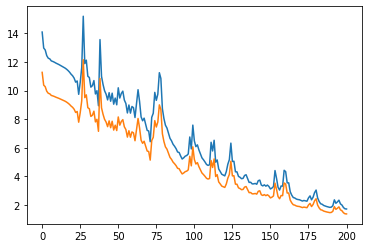

  0%|          | 1/200 [00:05<19:41,  5.94s/it]

nnodes: 2, seq_range 150 epoch: 1


  1%|          | 2/200 [00:11<19:25,  5.89s/it]

loss: 1.677, val_loss 1.342
nnodes: 5, seq_range 100 epoch: 2


  2%|▏         | 3/200 [00:17<19:22,  5.90s/it]

loss: 1.640, val_loss 1.312
nnodes: 10, seq_range 200 epoch: 3


  2%|▏         | 4/200 [00:23<19:44,  6.05s/it]

loss: 1.626, val_loss 1.301
nnodes: 1, seq_range 150 epoch: 4


  2%|▎         | 5/200 [00:30<19:43,  6.07s/it]

loss: 1.603, val_loss 1.282
nnodes: 2, seq_range 100 epoch: 5


  3%|▎         | 6/200 [00:36<19:34,  6.05s/it]

loss: 1.619, val_loss 1.295
nnodes: 5, seq_range 200 epoch: 6


  4%|▎         | 7/200 [00:42<19:37,  6.10s/it]

loss: 1.663, val_loss 1.330
nnodes: 10, seq_range 150 epoch: 7


  4%|▍         | 8/200 [00:48<19:37,  6.13s/it]

loss: 1.688, val_loss 1.350
nnodes: 1, seq_range 100 epoch: 8


  4%|▍         | 9/200 [00:54<19:21,  6.08s/it]

loss: 2.038, val_loss 1.631
nnodes: 2, seq_range 200 epoch: 9


  5%|▌         | 10/200 [01:00<19:03,  6.02s/it]

loss: 1.928, val_loss 1.542
nnodes: 5, seq_range 150 epoch: 10
loss: 2.227, val_loss 1.781


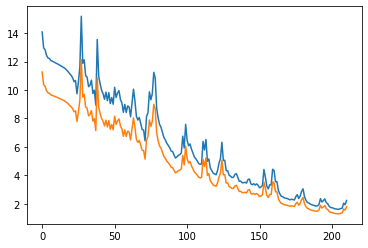

  6%|▌         | 11/200 [01:06<19:15,  6.11s/it]

nnodes: 10, seq_range 100 epoch: 11


  6%|▌         | 12/200 [01:12<19:15,  6.15s/it]

loss: 2.633, val_loss 2.106
nnodes: 1, seq_range 200 epoch: 12


  6%|▋         | 13/200 [01:18<18:43,  6.01s/it]

loss: 2.235, val_loss 1.788
nnodes: 2, seq_range 150 epoch: 13


  7%|▋         | 14/200 [01:24<18:27,  5.96s/it]

loss: 1.694, val_loss 1.355
nnodes: 5, seq_range 100 epoch: 14


  8%|▊         | 15/200 [01:30<18:14,  5.91s/it]

loss: 1.578, val_loss 1.263
nnodes: 10, seq_range 200 epoch: 15


  8%|▊         | 16/200 [01:36<18:04,  5.89s/it]

loss: 1.634, val_loss 1.307
nnodes: 1, seq_range 150 epoch: 16


  8%|▊         | 17/200 [01:41<17:47,  5.83s/it]

loss: 1.606, val_loss 1.285
nnodes: 2, seq_range 100 epoch: 17


  9%|▉         | 18/200 [01:47<17:35,  5.80s/it]

loss: 1.557, val_loss 1.245
nnodes: 5, seq_range 200 epoch: 18


 10%|▉         | 19/200 [01:53<17:27,  5.79s/it]

loss: 1.462, val_loss 1.169
nnodes: 10, seq_range 150 epoch: 19


 10%|█         | 20/200 [01:59<17:24,  5.81s/it]

loss: 1.474, val_loss 1.179
nnodes: 1, seq_range 100 epoch: 20
loss: 1.538, val_loss 1.230


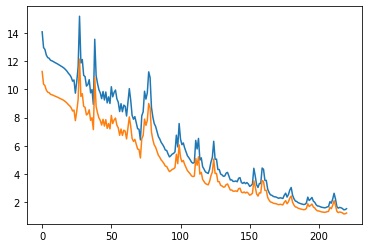

 10%|█         | 21/200 [02:04<17:18,  5.80s/it]

nnodes: 2, seq_range 200 epoch: 21


 11%|█         | 22/200 [02:10<17:05,  5.76s/it]

loss: 1.557, val_loss 1.245
nnodes: 5, seq_range 150 epoch: 22


 12%|█▏        | 23/200 [02:16<16:58,  5.76s/it]

loss: 1.514, val_loss 1.211
nnodes: 10, seq_range 100 epoch: 23


 12%|█▏        | 24/200 [02:22<16:59,  5.79s/it]

loss: 1.707, val_loss 1.366
nnodes: 1, seq_range 200 epoch: 24


 12%|█▎        | 25/200 [02:27<16:46,  5.75s/it]

loss: 1.769, val_loss 1.415
nnodes: 2, seq_range 150 epoch: 25


 13%|█▎        | 26/200 [02:33<16:37,  5.73s/it]

loss: 1.638, val_loss 1.311
nnodes: 5, seq_range 100 epoch: 26


 14%|█▎        | 27/200 [02:39<16:34,  5.75s/it]

loss: 1.777, val_loss 1.421
nnodes: 10, seq_range 200 epoch: 27


 14%|█▍        | 28/200 [02:45<16:44,  5.84s/it]

loss: 1.488, val_loss 1.190
nnodes: 1, seq_range 150 epoch: 28


 14%|█▍        | 29/200 [02:51<16:42,  5.86s/it]

loss: 1.428, val_loss 1.143
nnodes: 2, seq_range 100 epoch: 29


 15%|█▌        | 30/200 [02:57<16:39,  5.88s/it]

loss: 1.319, val_loss 1.055
nnodes: 5, seq_range 200 epoch: 30
loss: 1.314, val_loss 1.051


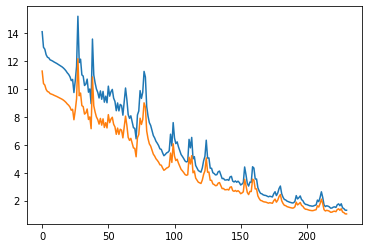

 16%|█▌        | 31/200 [03:03<16:49,  5.97s/it]

nnodes: 10, seq_range 150 epoch: 31


 16%|█▌        | 32/200 [03:09<16:38,  5.94s/it]

loss: 1.345, val_loss 1.076
nnodes: 1, seq_range 100 epoch: 32


 16%|█▋        | 33/200 [03:15<16:51,  6.06s/it]

loss: 1.324, val_loss 1.059
nnodes: 2, seq_range 200 epoch: 33


 17%|█▋        | 34/200 [03:21<16:49,  6.08s/it]

loss: 1.304, val_loss 1.043
nnodes: 5, seq_range 150 epoch: 34


 18%|█▊        | 35/200 [03:27<16:34,  6.03s/it]

loss: 1.481, val_loss 1.185
nnodes: 10, seq_range 100 epoch: 35


 18%|█▊        | 36/200 [03:33<16:24,  6.00s/it]

loss: 1.420, val_loss 1.136
nnodes: 1, seq_range 200 epoch: 36


 18%|█▊        | 37/200 [03:39<16:02,  5.90s/it]

loss: 1.311, val_loss 1.049
nnodes: 2, seq_range 150 epoch: 37


 19%|█▉        | 38/200 [03:45<15:50,  5.86s/it]

loss: 1.396, val_loss 1.117
nnodes: 5, seq_range 100 epoch: 38


 20%|█▉        | 39/200 [03:51<16:06,  6.00s/it]

loss: 1.322, val_loss 1.058
nnodes: 10, seq_range 200 epoch: 39


 20%|██        | 40/200 [03:57<15:57,  5.99s/it]

loss: 1.264, val_loss 1.011
nnodes: 1, seq_range 150 epoch: 40
loss: 1.309, val_loss 1.048


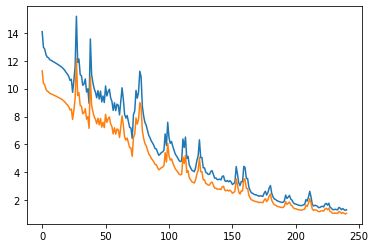

 20%|██        | 41/200 [04:03<15:42,  5.93s/it]

nnodes: 2, seq_range 100 epoch: 41


 21%|██        | 42/200 [04:09<15:40,  5.95s/it]

loss: 1.252, val_loss 1.002
nnodes: 5, seq_range 200 epoch: 42


 22%|██▏       | 43/200 [04:15<15:31,  5.94s/it]

loss: 1.220, val_loss 0.976
nnodes: 10, seq_range 150 epoch: 43


 22%|██▏       | 44/200 [04:20<15:27,  5.95s/it]

loss: 1.320, val_loss 1.056
nnodes: 1, seq_range 100 epoch: 44


 22%|██▎       | 45/200 [04:26<15:11,  5.88s/it]

loss: 1.278, val_loss 1.022
nnodes: 2, seq_range 200 epoch: 45


 23%|██▎       | 46/200 [04:32<14:57,  5.83s/it]

loss: 1.224, val_loss 0.979
nnodes: 5, seq_range 150 epoch: 46


 24%|██▎       | 47/200 [04:38<14:49,  5.81s/it]

loss: 1.316, val_loss 1.053
nnodes: 10, seq_range 100 epoch: 47


 24%|██▍       | 48/200 [04:44<14:47,  5.84s/it]

loss: 1.271, val_loss 1.017
nnodes: 1, seq_range 200 epoch: 48


 24%|██▍       | 49/200 [04:49<14:35,  5.80s/it]

loss: 1.243, val_loss 0.995
nnodes: 2, seq_range 150 epoch: 49


 25%|██▌       | 50/200 [04:55<14:24,  5.76s/it]

loss: 1.243, val_loss 0.995
nnodes: 5, seq_range 100 epoch: 50
loss: 1.181, val_loss 0.945


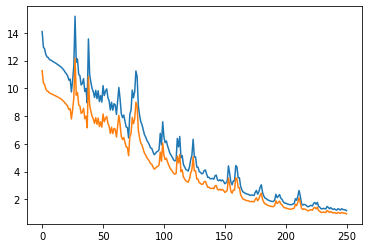

 26%|██▌       | 51/200 [05:01<14:24,  5.80s/it]

nnodes: 10, seq_range 200 epoch: 51


 26%|██▌       | 52/200 [05:07<14:20,  5.81s/it]

loss: 1.171, val_loss 0.937
nnodes: 1, seq_range 150 epoch: 52


 26%|██▋       | 53/200 [05:12<14:07,  5.77s/it]

loss: 1.188, val_loss 0.951
nnodes: 2, seq_range 100 epoch: 53


 27%|██▋       | 54/200 [05:18<13:59,  5.75s/it]

loss: 1.100, val_loss 0.880
nnodes: 5, seq_range 200 epoch: 54


 28%|██▊       | 55/200 [05:24<13:56,  5.77s/it]

loss: 1.086, val_loss 0.869
nnodes: 10, seq_range 150 epoch: 55


 28%|██▊       | 56/200 [05:30<13:54,  5.80s/it]

loss: 1.150, val_loss 0.920
nnodes: 1, seq_range 100 epoch: 56


 28%|██▊       | 57/200 [05:35<13:44,  5.76s/it]

loss: 1.084, val_loss 0.867
nnodes: 2, seq_range 200 epoch: 57


 29%|██▉       | 58/200 [05:41<13:34,  5.74s/it]

loss: 1.071, val_loss 0.857
nnodes: 5, seq_range 150 epoch: 58


 30%|██▉       | 59/200 [05:47<13:31,  5.75s/it]

loss: 1.187, val_loss 0.950
nnodes: 10, seq_range 100 epoch: 59


 30%|███       | 60/200 [05:53<13:30,  5.79s/it]

loss: 1.140, val_loss 0.912
nnodes: 1, seq_range 200 epoch: 60
loss: 1.129, val_loss 0.903
setting lr to 0.000


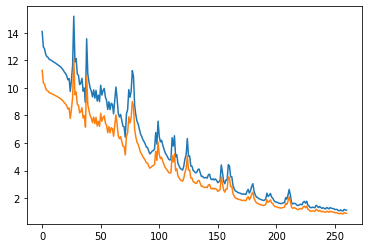

 30%|███       | 61/200 [05:59<13:22,  5.77s/it]

nnodes: 2, seq_range 150 epoch: 61


 31%|███       | 62/200 [06:04<13:13,  5.75s/it]

loss: 1.193, val_loss 0.954
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 62


 32%|███▏      | 63/200 [06:10<13:07,  5.75s/it]

loss: 1.181, val_loss 0.945
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 63


 32%|███▏      | 64/200 [06:16<13:05,  5.78s/it]

loss: 1.161, val_loss 0.928
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 64


 32%|███▎      | 65/200 [06:21<12:55,  5.75s/it]

loss: 1.141, val_loss 0.913
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 65


 33%|███▎      | 66/200 [06:27<12:50,  5.75s/it]

loss: 0.964, val_loss 0.771
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 66


 34%|███▎      | 67/200 [06:33<12:44,  5.75s/it]

loss: 0.961, val_loss 0.769
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 67


 34%|███▍      | 68/200 [06:39<12:42,  5.77s/it]

loss: 0.891, val_loss 0.713
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 68


 34%|███▍      | 69/200 [06:44<12:32,  5.75s/it]

loss: 0.839, val_loss 0.671
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 69


 35%|███▌      | 70/200 [06:50<12:22,  5.71s/it]

loss: 0.828, val_loss 0.663
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 70
loss: 0.835, val_loss 0.668
setting lr to 0.000


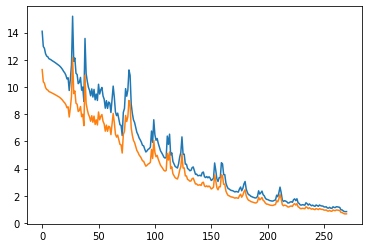

 36%|███▌      | 71/200 [06:56<12:23,  5.76s/it]

nnodes: 10, seq_range 100 epoch: 71


 36%|███▌      | 72/200 [07:02<12:20,  5.79s/it]

loss: 0.809, val_loss 0.647
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 72


 36%|███▋      | 73/200 [07:08<12:09,  5.75s/it]

loss: 0.805, val_loss 0.644
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 73


 37%|███▋      | 74/200 [07:13<12:02,  5.73s/it]

loss: 0.877, val_loss 0.702
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 74


 38%|███▊      | 75/200 [07:19<11:59,  5.76s/it]

loss: 0.805, val_loss 0.644
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 75


 38%|███▊      | 76/200 [07:25<11:56,  5.78s/it]

loss: 0.778, val_loss 0.622
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 76


 38%|███▊      | 77/200 [07:30<11:46,  5.74s/it]

loss: 0.821, val_loss 0.657
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 77


 39%|███▉      | 78/200 [07:36<11:39,  5.73s/it]

loss: 0.762, val_loss 0.610
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 78


 40%|███▉      | 79/200 [07:42<11:34,  5.74s/it]

loss: 0.752, val_loss 0.602
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 79


 40%|████      | 80/200 [07:48<11:33,  5.78s/it]

loss: 0.781, val_loss 0.625
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 80
loss: 0.783, val_loss 0.626
setting lr to 0.000


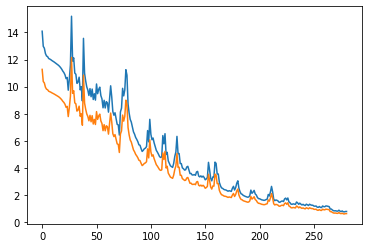

 40%|████      | 81/200 [07:54<11:27,  5.78s/it]

nnodes: 2, seq_range 200 epoch: 81


 41%|████      | 82/200 [07:59<11:18,  5.75s/it]

loss: 0.814, val_loss 0.651
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 82


 42%|████▏     | 83/200 [08:05<11:11,  5.74s/it]

loss: 0.815, val_loss 0.652
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 83


 42%|████▏     | 84/200 [08:11<11:10,  5.78s/it]

loss: 0.878, val_loss 0.702
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 84


 42%|████▎     | 85/200 [08:17<11:00,  5.74s/it]

loss: 0.804, val_loss 0.643
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 85


 43%|████▎     | 86/200 [08:22<10:54,  5.74s/it]

loss: 0.773, val_loss 0.618
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 86


 44%|████▎     | 87/200 [08:28<10:50,  5.75s/it]

loss: 0.727, val_loss 0.581
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 87


 44%|████▍     | 88/200 [08:34<10:45,  5.77s/it]

loss: 0.720, val_loss 0.576
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 88


 44%|████▍     | 89/200 [08:40<10:37,  5.74s/it]

loss: 0.727, val_loss 0.581
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 89


 45%|████▌     | 90/200 [08:45<10:28,  5.71s/it]

loss: 0.713, val_loss 0.571
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 90
loss: 0.658, val_loss 0.526
setting lr to 0.000


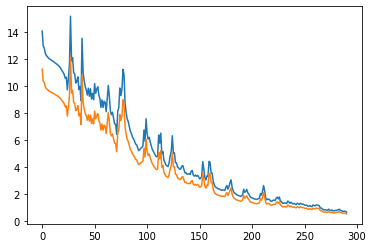

 46%|████▌     | 91/200 [08:51<10:28,  5.76s/it]

nnodes: 10, seq_range 150 epoch: 91


 46%|████▌     | 92/200 [08:57<10:25,  5.79s/it]

loss: 0.640, val_loss 0.512
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 92


 46%|████▋     | 93/200 [09:03<10:16,  5.76s/it]

loss: 0.620, val_loss 0.496
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 93


 47%|████▋     | 94/200 [09:08<10:07,  5.73s/it]

loss: 0.608, val_loss 0.487
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 94


 48%|████▊     | 95/200 [09:14<10:03,  5.75s/it]

loss: 0.602, val_loss 0.481
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 95


 48%|████▊     | 96/200 [09:20<10:02,  5.79s/it]

loss: 0.602, val_loss 0.482
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 96


 48%|████▊     | 97/200 [09:26<09:53,  5.76s/it]

loss: 0.598, val_loss 0.478
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 97


 49%|████▉     | 98/200 [09:31<09:46,  5.75s/it]

loss: 0.586, val_loss 0.469
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 98


 50%|████▉     | 99/200 [09:37<09:40,  5.75s/it]

loss: 0.601, val_loss 0.481
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 99


 50%|█████     | 100/200 [09:43<09:36,  5.76s/it]

loss: 0.592, val_loss 0.473
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 100
loss: 0.573, val_loss 0.459
setting lr to 0.000


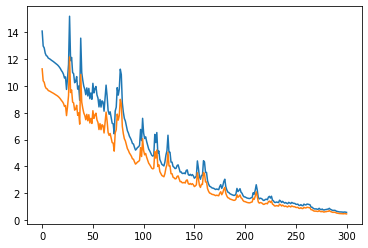

 50%|█████     | 101/200 [09:49<09:29,  5.76s/it]

nnodes: 2, seq_range 100 epoch: 101


 51%|█████     | 102/200 [09:54<09:21,  5.73s/it]

loss: 0.583, val_loss 0.466
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 102


 52%|█████▏    | 103/200 [10:00<09:15,  5.73s/it]

loss: 0.574, val_loss 0.459
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 103


 52%|█████▏    | 104/200 [10:06<09:12,  5.76s/it]

loss: 0.557, val_loss 0.445
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 104


 52%|█████▎    | 105/200 [10:12<09:05,  5.74s/it]

loss: 0.552, val_loss 0.441
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 105


 53%|█████▎    | 106/200 [10:17<08:58,  5.73s/it]

loss: 0.549, val_loss 0.439
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 106


 54%|█████▎    | 107/200 [10:23<08:57,  5.78s/it]

loss: 0.535, val_loss 0.428
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 107


 54%|█████▍    | 108/200 [10:29<08:53,  5.80s/it]

loss: 0.522, val_loss 0.417
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 108


 55%|█████▍    | 109/200 [10:35<08:43,  5.76s/it]

loss: 0.519, val_loss 0.415
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 109


 55%|█████▌    | 110/200 [10:40<08:33,  5.71s/it]

loss: 0.506, val_loss 0.405
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 110
loss: 0.489, val_loss 0.391
setting lr to 0.000


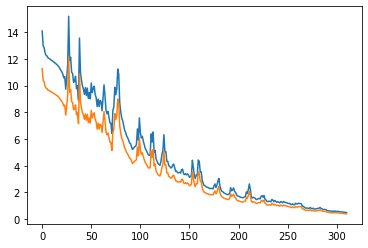

 56%|█████▌    | 111/200 [10:46<08:33,  5.77s/it]

nnodes: 10, seq_range 200 epoch: 111


 56%|█████▌    | 112/200 [10:52<08:30,  5.80s/it]

loss: 0.486, val_loss 0.389
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 112


 56%|█████▋    | 113/200 [10:58<08:21,  5.76s/it]

loss: 0.474, val_loss 0.380
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 113


 57%|█████▋    | 114/200 [11:03<08:14,  5.75s/it]

loss: 0.459, val_loss 0.367
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 114


 57%|█████▊    | 115/200 [11:09<08:08,  5.75s/it]

loss: 0.457, val_loss 0.365
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 115


 58%|█████▊    | 116/200 [11:15<08:05,  5.77s/it]

loss: 0.447, val_loss 0.358
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 116


 58%|█████▊    | 117/200 [11:21<07:56,  5.75s/it]

loss: 0.435, val_loss 0.348
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 117


 59%|█████▉    | 118/200 [11:26<07:50,  5.73s/it]

loss: 0.434, val_loss 0.347
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 118


 60%|█████▉    | 119/200 [11:32<07:45,  5.74s/it]

loss: 0.425, val_loss 0.340
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 119


 60%|██████    | 120/200 [11:38<07:42,  5.78s/it]

loss: 0.415, val_loss 0.332
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 120
loss: 0.414, val_loss 0.331
setting lr to 0.000


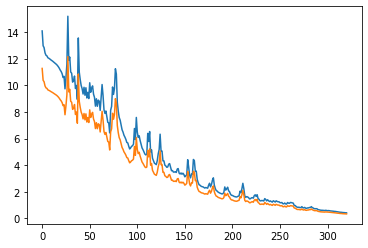

 60%|██████    | 121/200 [11:44<07:35,  5.77s/it]

nnodes: 2, seq_range 150 epoch: 121


 61%|██████    | 122/200 [11:49<07:28,  5.74s/it]

loss: 0.406, val_loss 0.325
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 122


 62%|██████▏   | 123/200 [11:55<07:22,  5.75s/it]

loss: 0.396, val_loss 0.317
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 123


 62%|██████▏   | 124/200 [12:01<07:18,  5.77s/it]

loss: 0.396, val_loss 0.317
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 124


 62%|██████▎   | 125/200 [12:07<07:10,  5.74s/it]

loss: 0.389, val_loss 0.311
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 125


 63%|██████▎   | 126/200 [12:12<07:04,  5.74s/it]

loss: 0.379, val_loss 0.303
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 126


 64%|██████▎   | 127/200 [12:18<06:58,  5.73s/it]

loss: 0.378, val_loss 0.303
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 127


 64%|██████▍   | 128/200 [12:24<06:54,  5.76s/it]

loss: 0.372, val_loss 0.297
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 128


 64%|██████▍   | 129/200 [12:30<06:47,  5.73s/it]

loss: 0.361, val_loss 0.289
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 129


 65%|██████▌   | 130/200 [12:35<06:37,  5.68s/it]

loss: 0.360, val_loss 0.288
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 130
loss: 0.354, val_loss 0.283
setting lr to 0.000


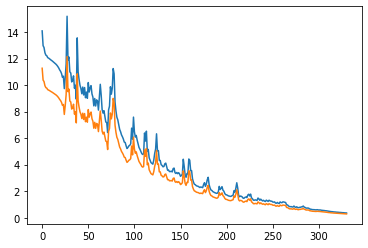

 66%|██████▌   | 131/200 [12:41<06:36,  5.74s/it]

nnodes: 10, seq_range 100 epoch: 131


 66%|██████▌   | 132/200 [12:47<06:33,  5.78s/it]

loss: 0.343, val_loss 0.274
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 132


 66%|██████▋   | 133/200 [12:53<06:25,  5.75s/it]

loss: 0.340, val_loss 0.272
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 133


 67%|██████▋   | 134/200 [12:58<06:18,  5.73s/it]

loss: 0.335, val_loss 0.268
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 134


 68%|██████▊   | 135/200 [13:04<06:14,  5.76s/it]

loss: 0.324, val_loss 0.259
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 135


 68%|██████▊   | 136/200 [13:10<06:09,  5.78s/it]

loss: 0.321, val_loss 0.257
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 136


 68%|██████▊   | 137/200 [13:16<06:01,  5.74s/it]

loss: 0.315, val_loss 0.252
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 137


 69%|██████▉   | 138/200 [13:21<05:55,  5.73s/it]

loss: 0.306, val_loss 0.244
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 138


 70%|██████▉   | 139/200 [13:27<05:50,  5.74s/it]

loss: 0.302, val_loss 0.241
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 139


 70%|███████   | 140/200 [13:33<05:46,  5.77s/it]

loss: 0.296, val_loss 0.237
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 140
loss: 0.288, val_loss 0.230
setting lr to 0.000


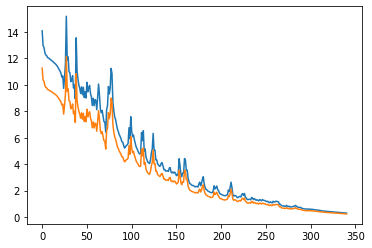

 70%|███████   | 141/200 [13:39<05:40,  5.77s/it]

nnodes: 2, seq_range 200 epoch: 141


 71%|███████   | 142/200 [13:44<05:32,  5.74s/it]

loss: 0.284, val_loss 0.227
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 142


 72%|███████▏  | 143/200 [13:50<05:26,  5.73s/it]

loss: 0.279, val_loss 0.223
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 143


 72%|███████▏  | 144/200 [13:56<05:22,  5.77s/it]

loss: 0.271, val_loss 0.217
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 144


 72%|███████▎  | 145/200 [14:02<05:14,  5.73s/it]

loss: 0.267, val_loss 0.214
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 145


 73%|███████▎  | 146/200 [14:07<05:10,  5.75s/it]

loss: 0.262, val_loss 0.210
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 146


 74%|███████▎  | 147/200 [14:13<05:08,  5.81s/it]

loss: 0.256, val_loss 0.205
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 147


 74%|███████▍  | 148/200 [14:19<05:02,  5.82s/it]

loss: 0.252, val_loss 0.201
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 148


 74%|███████▍  | 149/200 [14:25<04:54,  5.78s/it]

loss: 0.247, val_loss 0.198
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 149


 75%|███████▌  | 150/200 [14:31<04:46,  5.74s/it]

loss: 0.242, val_loss 0.193
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 150
loss: 0.237, val_loss 0.190
setting lr to 0.000


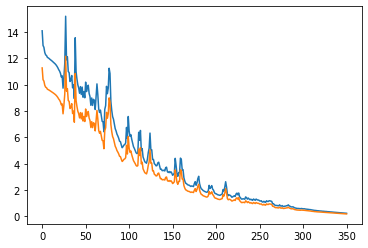

 76%|███████▌  | 151/200 [14:36<04:42,  5.77s/it]

nnodes: 10, seq_range 150 epoch: 151


 76%|███████▌  | 152/200 [14:42<04:37,  5.79s/it]

loss: 0.233, val_loss 0.186
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 152


 76%|███████▋  | 153/200 [14:48<04:30,  5.76s/it]

loss: 0.228, val_loss 0.182
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 153


 77%|███████▋  | 154/200 [14:54<04:24,  5.74s/it]

loss: 0.224, val_loss 0.179
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 154


 78%|███████▊  | 155/200 [14:59<04:18,  5.76s/it]

loss: 0.219, val_loss 0.175
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 155


 78%|███████▊  | 156/200 [15:05<04:14,  5.79s/it]

loss: 0.215, val_loss 0.172
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 156


 78%|███████▊  | 157/200 [15:11<04:07,  5.75s/it]

loss: 0.211, val_loss 0.168
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 157


 79%|███████▉  | 158/200 [15:17<04:01,  5.74s/it]

loss: 0.206, val_loss 0.165
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 158


 80%|███████▉  | 159/200 [15:22<03:56,  5.77s/it]

loss: 0.202, val_loss 0.162
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 159


 80%|████████  | 160/200 [15:28<03:51,  5.78s/it]

loss: 0.198, val_loss 0.158
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 160
loss: 0.194, val_loss 0.155
setting lr to 0.000


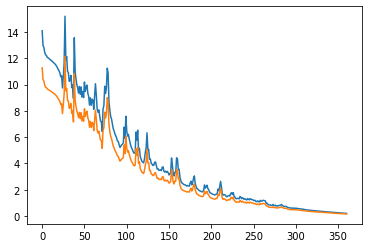

 80%|████████  | 161/200 [15:34<03:45,  5.78s/it]

nnodes: 2, seq_range 100 epoch: 161


 81%|████████  | 162/200 [15:40<03:39,  5.77s/it]

loss: 0.190, val_loss 0.152
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 162


 82%|████████▏ | 163/200 [15:46<03:33,  5.76s/it]

loss: 0.186, val_loss 0.149
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 163


 82%|████████▏ | 164/200 [15:51<03:28,  5.78s/it]

loss: 0.182, val_loss 0.145
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 164


 82%|████████▎ | 165/200 [15:57<03:21,  5.76s/it]

loss: 0.178, val_loss 0.142
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 165


 83%|████████▎ | 166/200 [16:03<03:15,  5.74s/it]

loss: 0.174, val_loss 0.139
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 166


 84%|████████▎ | 167/200 [16:09<03:09,  5.75s/it]

loss: 0.170, val_loss 0.136
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 167


 84%|████████▍ | 168/200 [16:14<03:05,  5.79s/it]

loss: 0.166, val_loss 0.133
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 168


 84%|████████▍ | 169/200 [16:20<02:57,  5.74s/it]

loss: 0.163, val_loss 0.130
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 169


 85%|████████▌ | 170/200 [16:26<02:51,  5.71s/it]

loss: 0.159, val_loss 0.127
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 170
loss: 0.155, val_loss 0.124
setting lr to 0.000


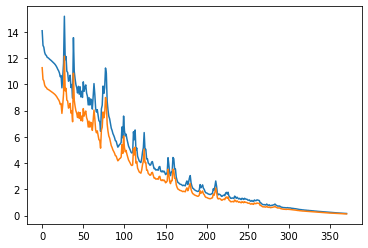

 86%|████████▌ | 171/200 [16:32<02:47,  5.76s/it]

nnodes: 10, seq_range 200 epoch: 171


 86%|████████▌ | 172/200 [16:37<02:41,  5.78s/it]

loss: 0.152, val_loss 0.121
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 172


 86%|████████▋ | 173/200 [16:43<02:35,  5.75s/it]

loss: 0.148, val_loss 0.118
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 173


 87%|████████▋ | 174/200 [16:49<02:29,  5.75s/it]

loss: 0.144, val_loss 0.115
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 174


 88%|████████▊ | 175/200 [16:55<02:23,  5.75s/it]

loss: 0.141, val_loss 0.113
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 175


 88%|████████▊ | 176/200 [17:00<02:18,  5.78s/it]

loss: 0.137, val_loss 0.110
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 176


 88%|████████▊ | 177/200 [17:06<02:12,  5.76s/it]

loss: 0.134, val_loss 0.107
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 177


 89%|████████▉ | 178/200 [17:12<02:06,  5.73s/it]

loss: 0.130, val_loss 0.104
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 178


 90%|████████▉ | 179/200 [17:18<02:00,  5.74s/it]

loss: 0.127, val_loss 0.101
setting lr to 0.000
nnodes: 10, seq_range 100 epoch: 179


 90%|█████████ | 180/200 [17:23<01:55,  5.78s/it]

loss: 0.123, val_loss 0.099
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 180
loss: 0.120, val_loss 0.096
setting lr to 0.000


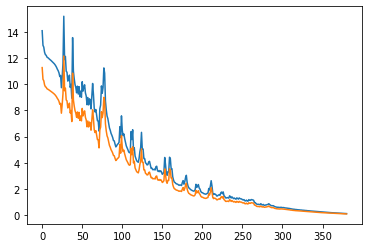

 90%|█████████ | 181/200 [17:29<01:49,  5.77s/it]

nnodes: 2, seq_range 150 epoch: 181


 91%|█████████ | 182/200 [17:35<01:43,  5.76s/it]

loss: 0.117, val_loss 0.093
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 182


 92%|█████████▏| 183/200 [17:41<01:37,  5.76s/it]

loss: 0.113, val_loss 0.091
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 183


 92%|█████████▏| 184/200 [17:47<01:32,  5.79s/it]

loss: 0.110, val_loss 0.088
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 184


 92%|█████████▎| 185/200 [17:52<01:26,  5.75s/it]

loss: 0.107, val_loss 0.085
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 185


 93%|█████████▎| 186/200 [17:58<01:20,  5.74s/it]

loss: 0.104, val_loss 0.083
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 186


 94%|█████████▎| 187/200 [18:04<01:14,  5.74s/it]

loss: 0.100, val_loss 0.080
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 187


 94%|█████████▍| 188/200 [18:09<01:09,  5.77s/it]

loss: 0.097, val_loss 0.078
setting lr to 0.000
nnodes: 1, seq_range 100 epoch: 188


 94%|█████████▍| 189/200 [18:15<01:03,  5.74s/it]

loss: 0.094, val_loss 0.075
setting lr to 0.000
nnodes: 2, seq_range 200 epoch: 189


 95%|█████████▌| 190/200 [18:21<00:57,  5.71s/it]

loss: 0.091, val_loss 0.073
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 190
loss: 0.088, val_loss 0.070
setting lr to 0.000


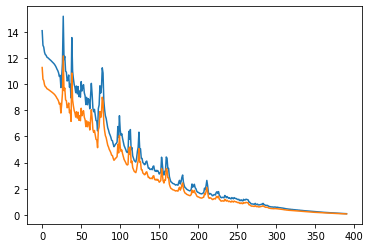

 96%|█████████▌| 191/200 [18:27<00:51,  5.76s/it]

nnodes: 10, seq_range 100 epoch: 191


 96%|█████████▌| 192/200 [18:33<00:46,  5.79s/it]

loss: 0.085, val_loss 0.068
setting lr to 0.000
nnodes: 1, seq_range 200 epoch: 192


 96%|█████████▋| 193/200 [18:38<00:40,  5.76s/it]

loss: 0.082, val_loss 0.065
setting lr to 0.000
nnodes: 2, seq_range 150 epoch: 193


 97%|█████████▋| 194/200 [18:44<00:34,  5.75s/it]

loss: 0.079, val_loss 0.063
setting lr to 0.000
nnodes: 5, seq_range 100 epoch: 194


 98%|█████████▊| 195/200 [18:50<00:28,  5.77s/it]

loss: 0.076, val_loss 0.061
setting lr to 0.000
nnodes: 10, seq_range 200 epoch: 195


 98%|█████████▊| 196/200 [18:56<00:23,  5.78s/it]

loss: 0.073, val_loss 0.058
setting lr to 0.000
nnodes: 1, seq_range 150 epoch: 196


 98%|█████████▊| 197/200 [19:01<00:17,  5.75s/it]

loss: 0.070, val_loss 0.056
setting lr to 0.000
nnodes: 2, seq_range 100 epoch: 197


 99%|█████████▉| 198/200 [19:07<00:11,  5.75s/it]

loss: 0.067, val_loss 0.054
setting lr to 0.000
nnodes: 5, seq_range 200 epoch: 198


100%|█████████▉| 199/200 [19:13<00:05,  5.78s/it]

loss: 0.064, val_loss 0.051
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 199


100%|██████████| 200/200 [19:19<00:00,  5.80s/it]

loss: 0.061, val_loss 0.049
setting lr to 0.000


In [21]:
n_epochs = 200
nbatch  = 600

edge_feat_size = 1
val_pct = 0.1
fixed_spacing_indices = False;
nnodes_schedule =     [1,2,5,10] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
nseq_range_schedule = [200,100,150];
min_spacing_schedule =[10];

nnodes_schedule =     [1,2,5,10] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
nseq_range_schedule = [200,150,100];
min_spacing_schedule =[10];


for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    graph_curr_data_multibatch, y_curr_data_multibatch = get_multi_batch_rnn(
        nbatch, source_ds=True,
        nnodes=nnodes,
        min_spacing = min_spacing,
        nseq_range = nseq_range,
        fixed_spacing_indices=fixed_spacing_indices, 
        edge_feat_size = edge_feat_size);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch, y_curr_data_batch in zip(graph_curr_data_multibatch, y_curr_data_multibatch):
        with tf.GradientTape() as tape:
            graph_curr, dt_curr = single_minibatch;
            
            prob_out = rnn_gamma_model((dt_curr,graph_curr))
            all_weights = rnn_gamma_model.weights#[*gn.weights(), *graph_indep.weights()];
            loss_vals = -prob_out.log_prob(y_curr_data_batch[np.newaxis].T) #* (1.2 - y_curr[np.newaxis].T)**2
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];

            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = all_weights
            #all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr_data)

            
       
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        

In [24]:
b = get_multi_batch_local(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices)




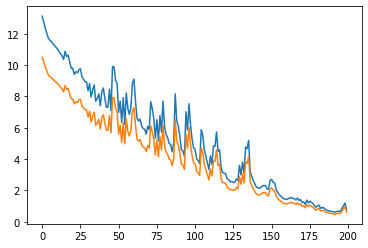

In [25]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


10


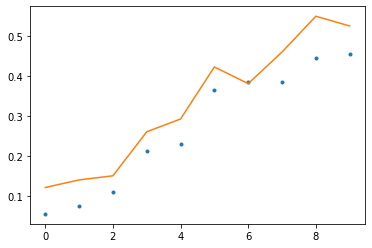

In [22]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)

ids_sort = np.argsort(y_curr_data_batch.flatten());
pplot.plot(y_curr_data_batch.flatten()[ids_sort],'.')
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [23]:

#prob_out.mean()
#ids_sort

In [24]:
cell.h_cnn.weights

[<tf.Variable 'conv_fcnA/kernel:0' shape=(1, 2, 50) dtype=float32, numpy=
 array([[[-0.03654684,  0.32503957,  0.25697348, -0.25950122,
           0.07942817, -0.10088684,  0.13826972, -0.39344645,
           0.36794436, -0.08423161,  0.13212357,  0.12232236,
           0.21427113, -0.00580021, -0.17735232,  0.24680026,
          -0.30819887, -0.05232951,  0.12499449,  0.22768465,
          -0.32839203, -0.3601363 , -0.09011958,  0.05874518,
          -0.17361099,  0.02679502, -0.32574818, -0.16048239,
          -0.10323314, -0.02519781,  0.04797955, -0.21012022,
           0.29962283,  0.20596647,  0.17920953,  0.2572411 ,
          -0.25923988,  0.26709956,  0.0325014 ,  0.0551338 ,
          -0.07425702,  0.13479929, -0.20265876, -0.29725513,
           0.26552424,  0.20152873, -0.04224592, -0.39038792,
           0.20382518, -0.35844207],
         [ 0.1202767 , -0.02433488, -0.24286953,  0.23858921,
           0.35582584,  0.2816443 , -0.3056454 ,  0.02781191,
           0.36228263

In [25]:
ee = 1
nnodes = 1
nsampled = 10
graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh, yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, nnodes=nnodes)
rnn_dat = graph_dat_to_rnn_dat(graphs,1)

In [26]:
res = rnn_gamma_model((rnn_dat[1], rnn_dat[0]))


In [27]:
normalization_factor_time = DATASET.normalization_factor_time

In [34]:
csfont = {'fontname':'Times New Roman','fontsize' : 24}

def plot_experiments_rnn(experiments_to_plot, nseq_len = None, xaxis_sample = False):
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,int(10/3*len(experiments_to_plot))), dpi = 300)
    nnodes_list = [1,10,15]#,3,5]
    if nseq_len is None:
        nseq_len = [200,200,200]
    
    minspacing= [10,10,10]
#     gnsteps  = [ 7,7,7] # not used.
    
    normalization_factor_time = DATASET.normalization_factor_time
    
    kk = 0;
    for exp_index, ee in enumerate( experiments_to_plot):
        for nnodes, nseq_,minspacing_ in zip(nnodes_list,  nseq_len, minspacing):
                
            #ee = training[0]
            graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                             yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            
            
            #probs = gn_tot.eval_graphnets(graphs,gnsteps_,eval_mode = eval_mode)
            d = graph_dat_to_rnn_dat(graphs,1)
            dat_ = [d[1] ,d[0]]
            
            probs = rnn_gamma_model(dat_)
            ids_sorted = np.argsort(y_times)
            time_grid = np.linspace(np.min(y_times), 75000./normalization_factor_time, 150)
            
            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T

            y_times_sorted = y_times[ids_sorted];
            y_times_sorted_unnorm = y_times_sorted * normalization_factor_time;
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]
            tohours = lambda x : x / 3600

            if xaxis_sample:
                pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.5, cmap = "gray", linewidth = 3)
            else:
                pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
                pplot.plot(tohours(y_times_sorted_unnorm), tohours(y_times_sorted  *normalization_factor_time), linewidth = 7)
            

            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            pplot.plot(tohours(y_times_sorted_unnorm),tohours(q90*femto_dataset.normalization_factor_time),'C1-.', alpha = 0.4, linewidth = 3)
            pplot.ylim(0,tohours(75000))
            
            if nnodes == 1:
                #pplot.ylabel("Experiment %i/%s\nPredicted RUL[h]"%(ee,femto_dataset.file_suffix[ee]), fontsize = 20)
                pplot.ylabel("Experiment %s\nPredicted RUL[h]"%(femto_dataset.file_suffix[ee]), **csfont)
            
            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))


            if exp_index == 0:
                title = "Obs.:%i\nNLL:%2.3f"%(nnodes,nll)
            else:
                title = "NLL:%2.3f"%(nll)
                
            if exp_index == (len(experiments_to_plot)-1):
                pplot.xlabel("Actual RUL[h]", **csfont)
                
            pplot.title(title, **csfont)

            kk+=1
            #p_y.shape
            #pplot.show()
    pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
    #pplot.show()
    

<ipython-input-34-70df0bb71cd9>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-34-70df0bb71cd9>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-34-70df0bb71cd9>:48: Ma

<ipython-input-34-70df0bb71cd9>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-34-70df0bb71cd9>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")


ValueError: 'a' cannot be empty unless no samples are taken

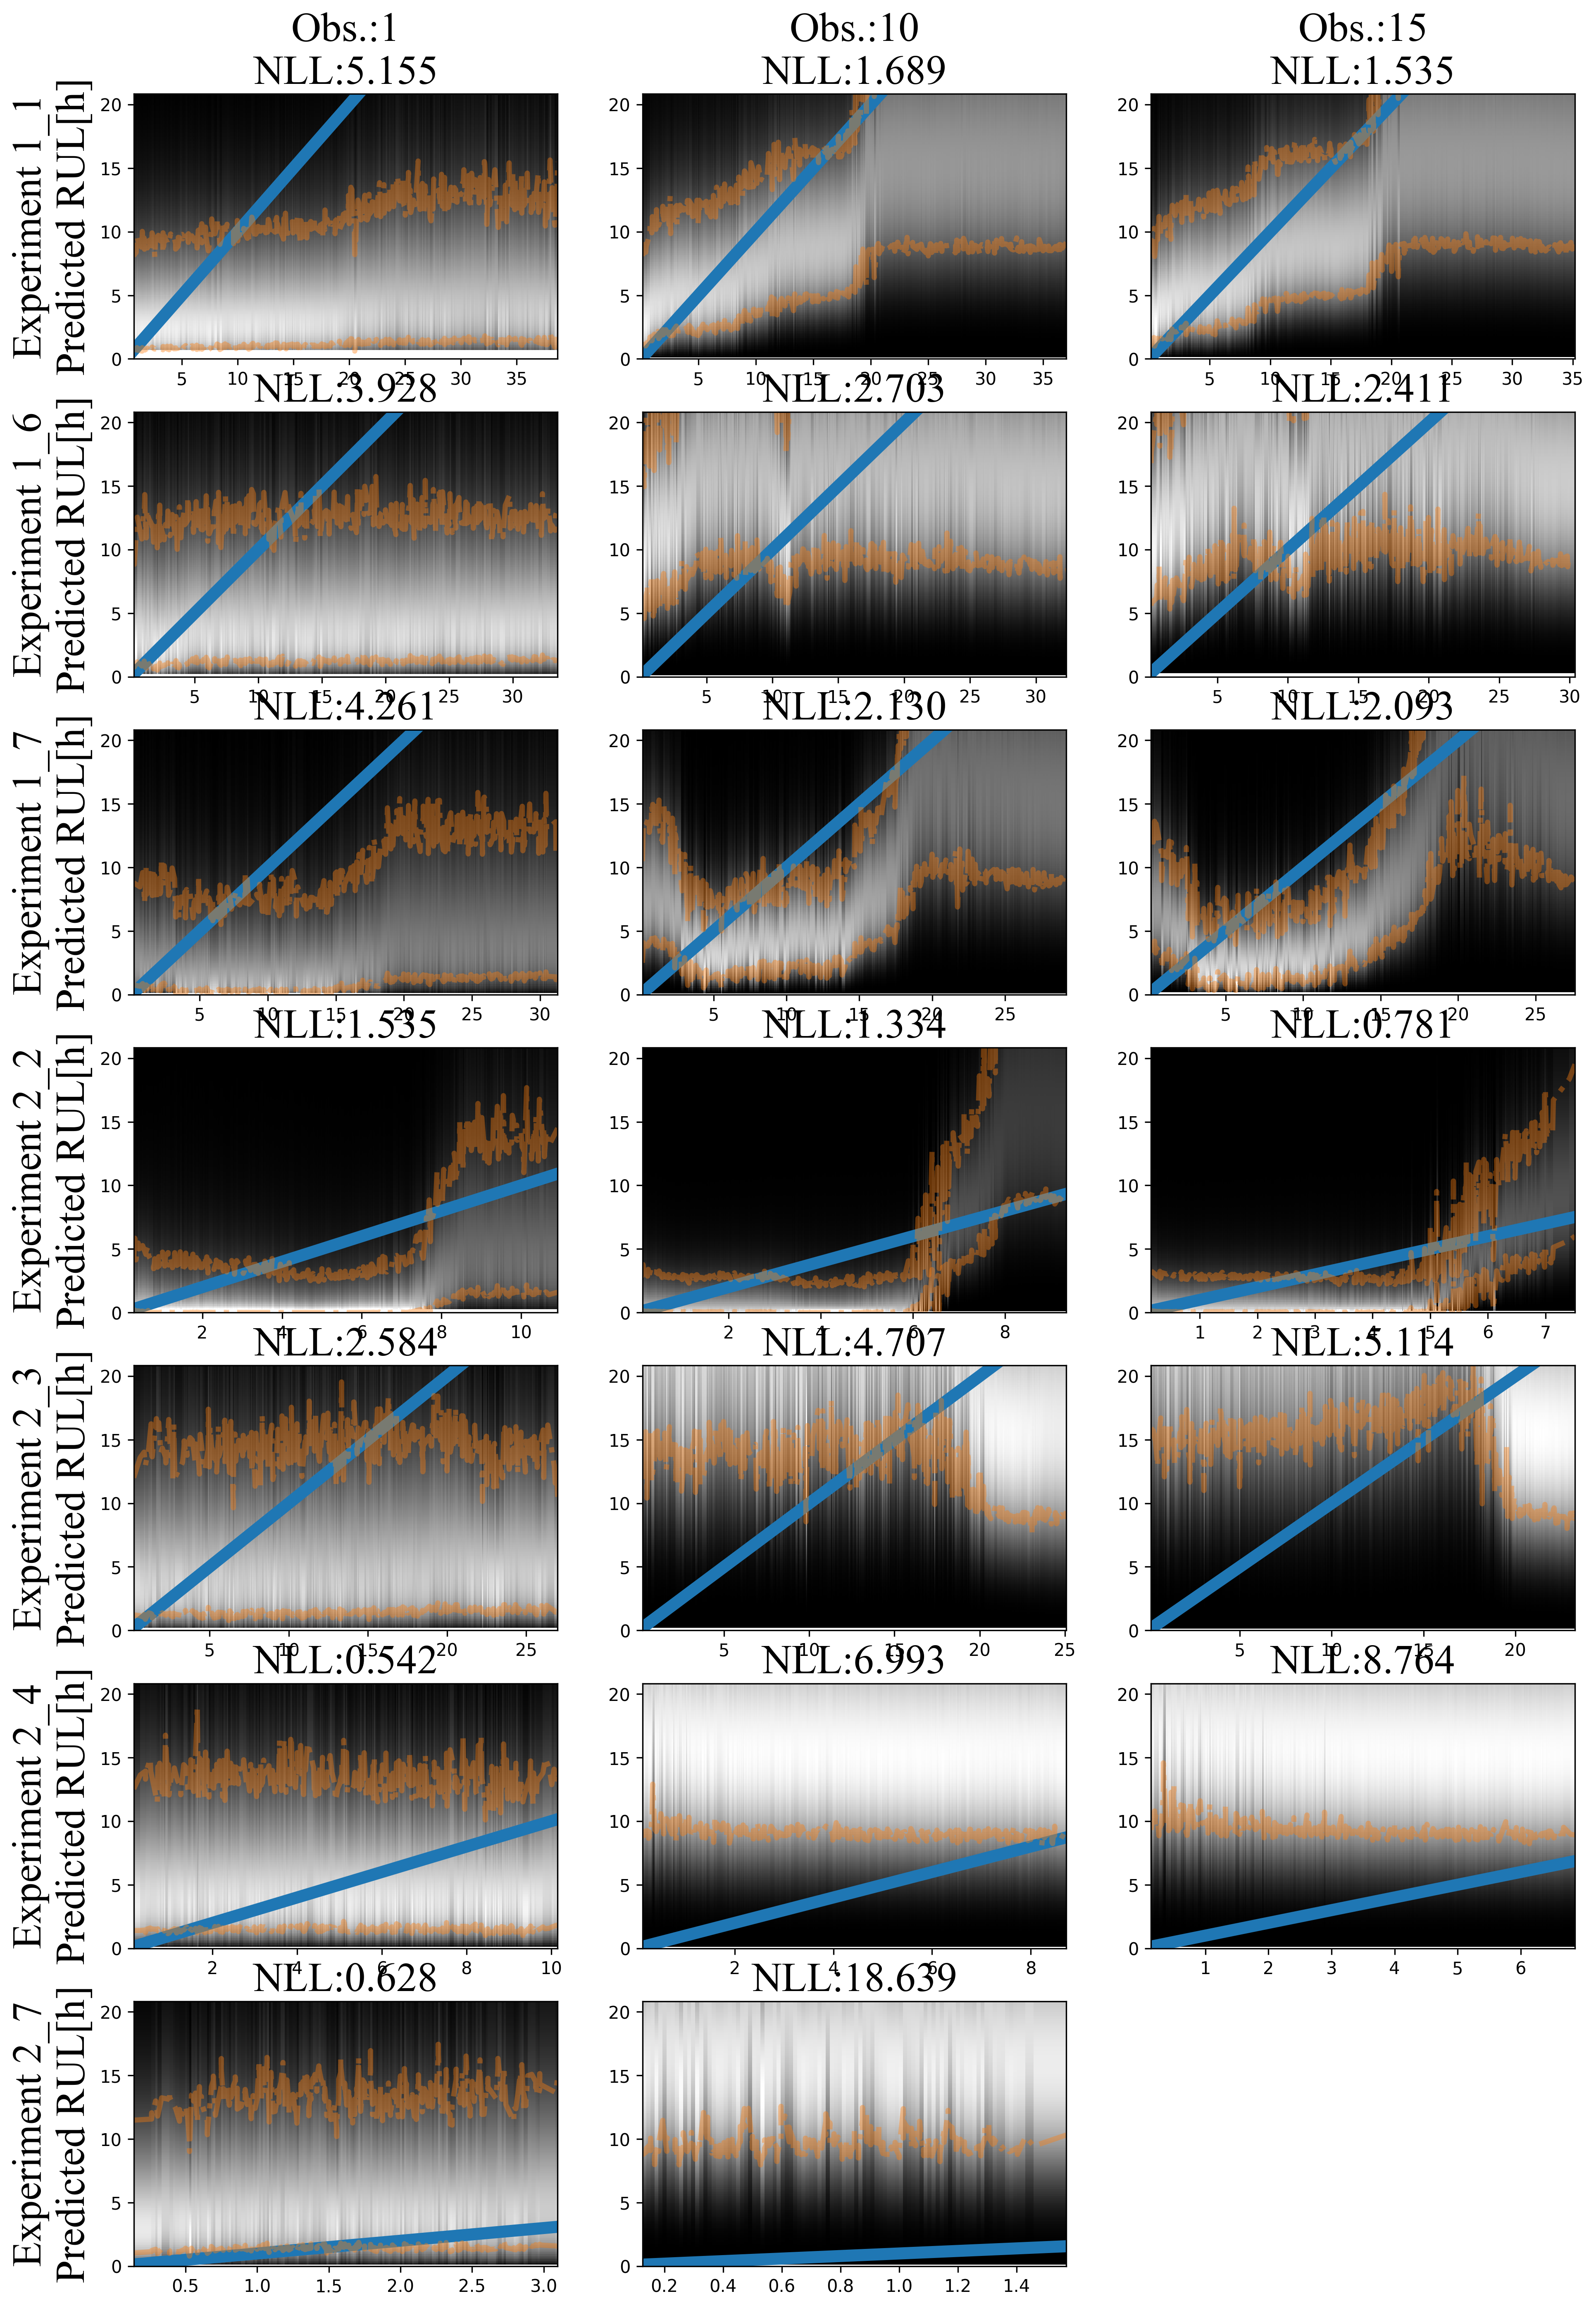

In [35]:
non_training =[ v_ for v_ in np.unique(DATASET.eid) if v_ not in DATASET.inds_exp_source]
suff = 'rnn_r1'
#plot_experiments(targets[0:2])
# plot_experiments_rnn(non_training[0:3],nseq_len=[100,150,300])
plot_experiments_rnn(non_training,nseq_len=[100,150,300])
pplot.savefig("TestSet_Exp_1_%s.png"%suff)
#pplot.savefig("TestSet_Exp_1_b.pdf")

# plot_experiments_rnn(non_training[3:6],nseq_len=[100,150,200])
# pplot.savefig("TestSet_Exp_2_%s.png"%suff)
# #pplot.savefig("TestSet_Exp_2_b.pdf")

# plot_experiments_rnn(non_training[6:9],nseq_len=[100,150,200])
# pplot.savefig("TestSet_Exp_3_%s.png"%suff)
# #pplot.savefig("TestSet_Exp_3_b.pdf")

# plot_experiments_rnn(non_training[9:],nseq_len=[100,150,200])



In [34]:
#!cp TestSet_Exp_1_rnn_r1.png /home/charilaos/current/paper/figures/test_set_RNN-tCNN.png

<ipython-input-32-5cee02fc4b19>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-32-5cee02fc4b19>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")


ValueError: Cannot take a larger sample than population when 'replace=False'

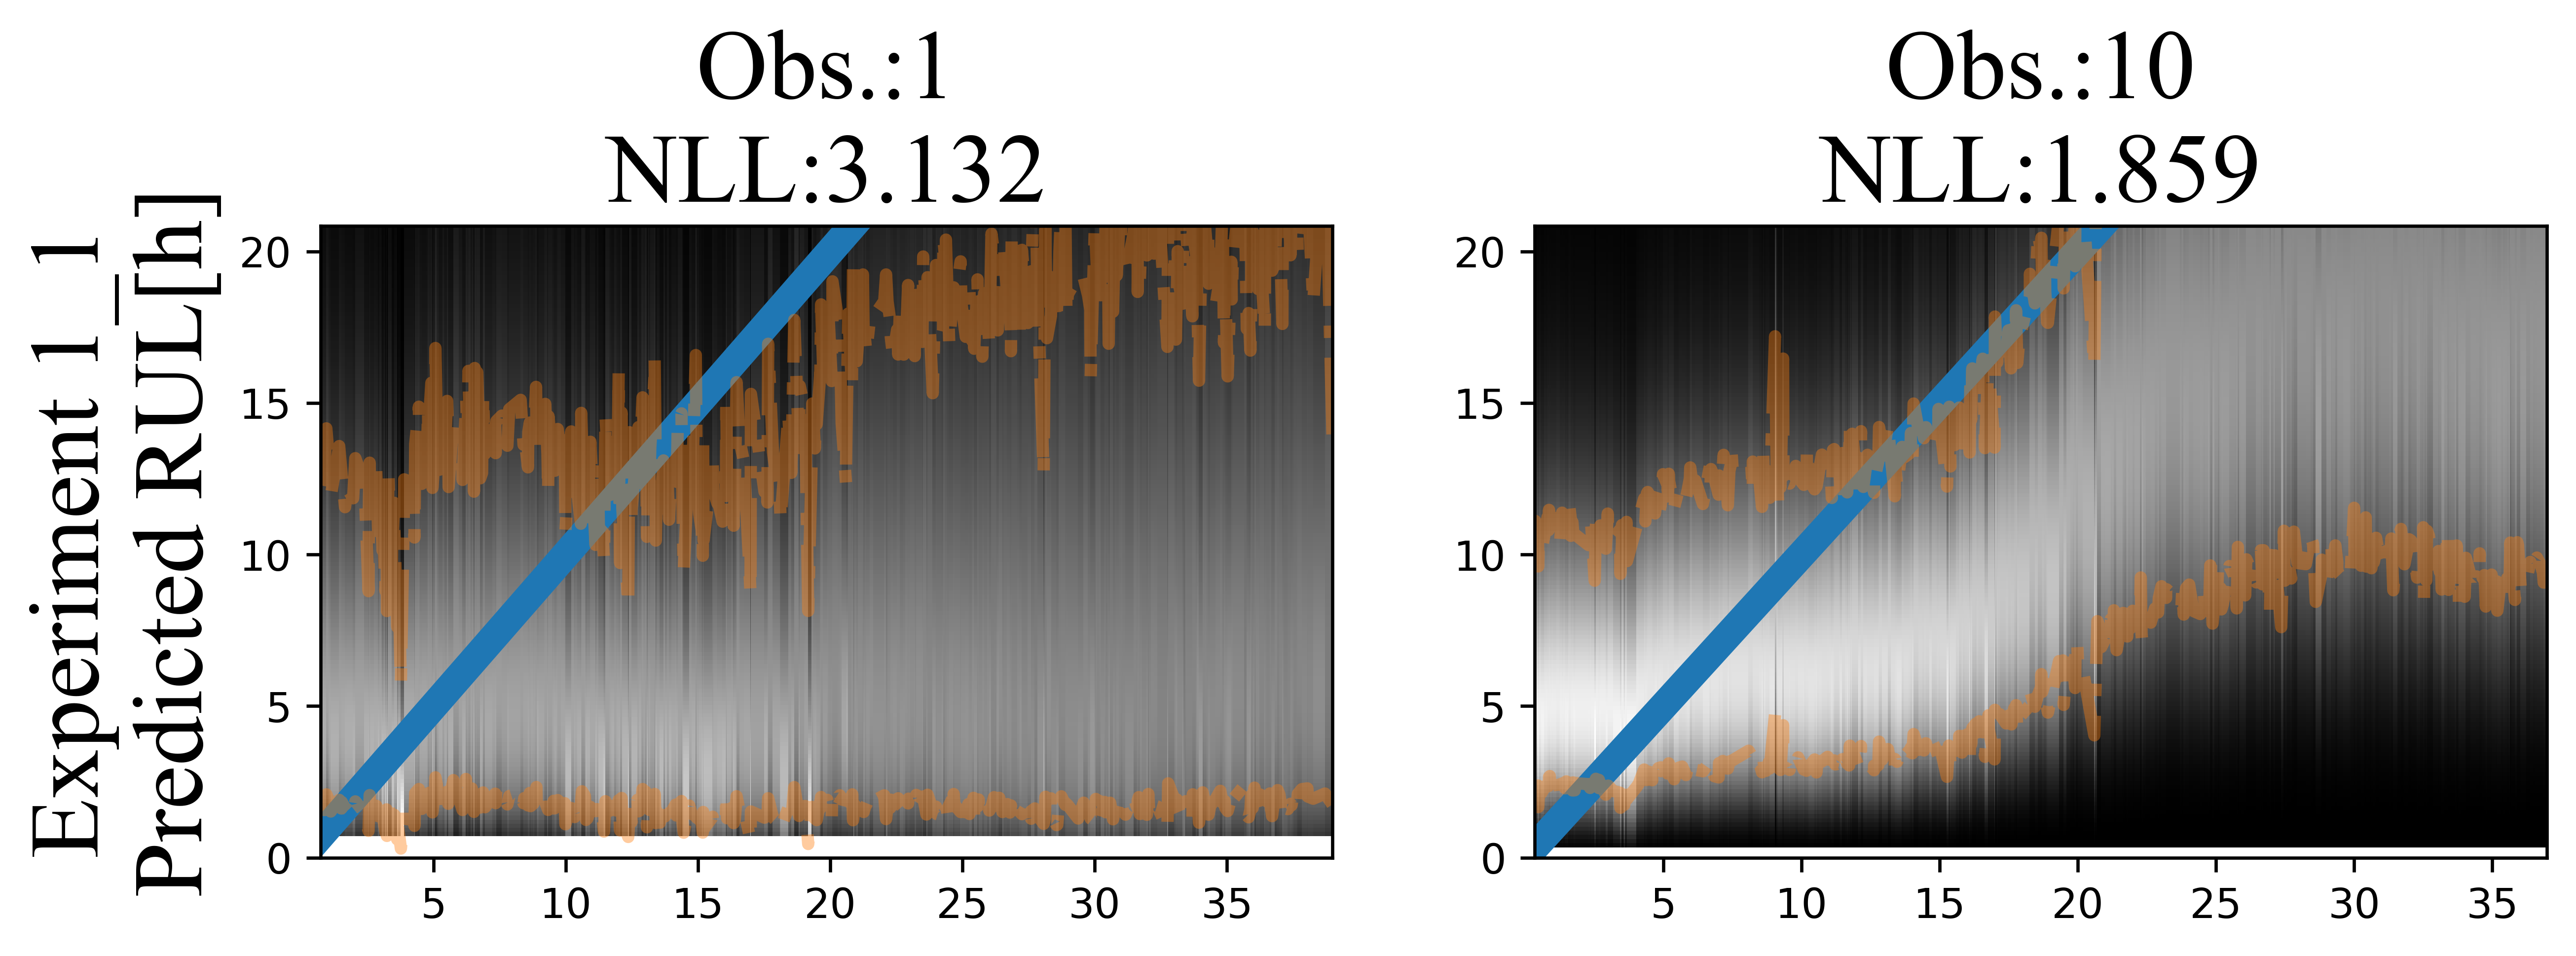

In [36]:
non_training =[ v_ for v_ in np.unique(DATASET.eid) if v_ not in DATASET.inds_exp_source]

tt = [non_training[k_] for k_ in [0,1,3,8]]
plot_experiments_rnn(tt, nseq_len=[100,150,250])
pplot.savefig("test_set_examples_rnn_unequal.png")

In [42]:
gdat ,  dt_dat  = graph_dat_to_rnn_dat(graphs)

In [50]:
gdat.shape

(500, 15, 2559, 2)

In [62]:
err_vals = {}
for ee in femto_dataset.inds_exp_target:
    nseq_ = 200
    nsampled = 500
    nnodes = 15
    minspacing_ = 5
    fid = femto_dataset.file_suffix[ee]
    graphs, y_times = get_graph_data(ee, X_ = femto_dataset.X, eid_oh_ = femto_dataset.eid_oh,
                                                 yrem_norm_ = femto_dataset.yrem_norm, n_sampled_graphs = nsampled, 
                                                 nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                                 nseq_range=nseq_)
    
    gdat ,  dt_dat  = graph_dat_to_rnn_dat(graphs)

    probs = rnn_gamma_model((dt_dat,gdat))
    
    vv = probs.mode()
    nanmask  = ~np.isnan(vv).flatten()
    vv = vv[nanmask]
    y_times = y_times[nanmask]
    
    mm= np.mean(tf.keras.losses.mape(vv , y_times).numpy())
    print(mm)
    err_vals.update({fid : mm})

133.66531
70.37859
384.1191
5506.2524
47.21632
81.85802
98.206406
89.82586
59.67114


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [56]:
y_times.shape, gdat.shape

((500,), (500, 15, 2559, 2))

(500, 15, 2559, 2)

<ipython-input-32-5cee02fc4b19>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-32-5cee02fc4b19>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted]**0.5, cmap = "gray")
<ipython-input-32-5cee02fc4b19>:47: Ma

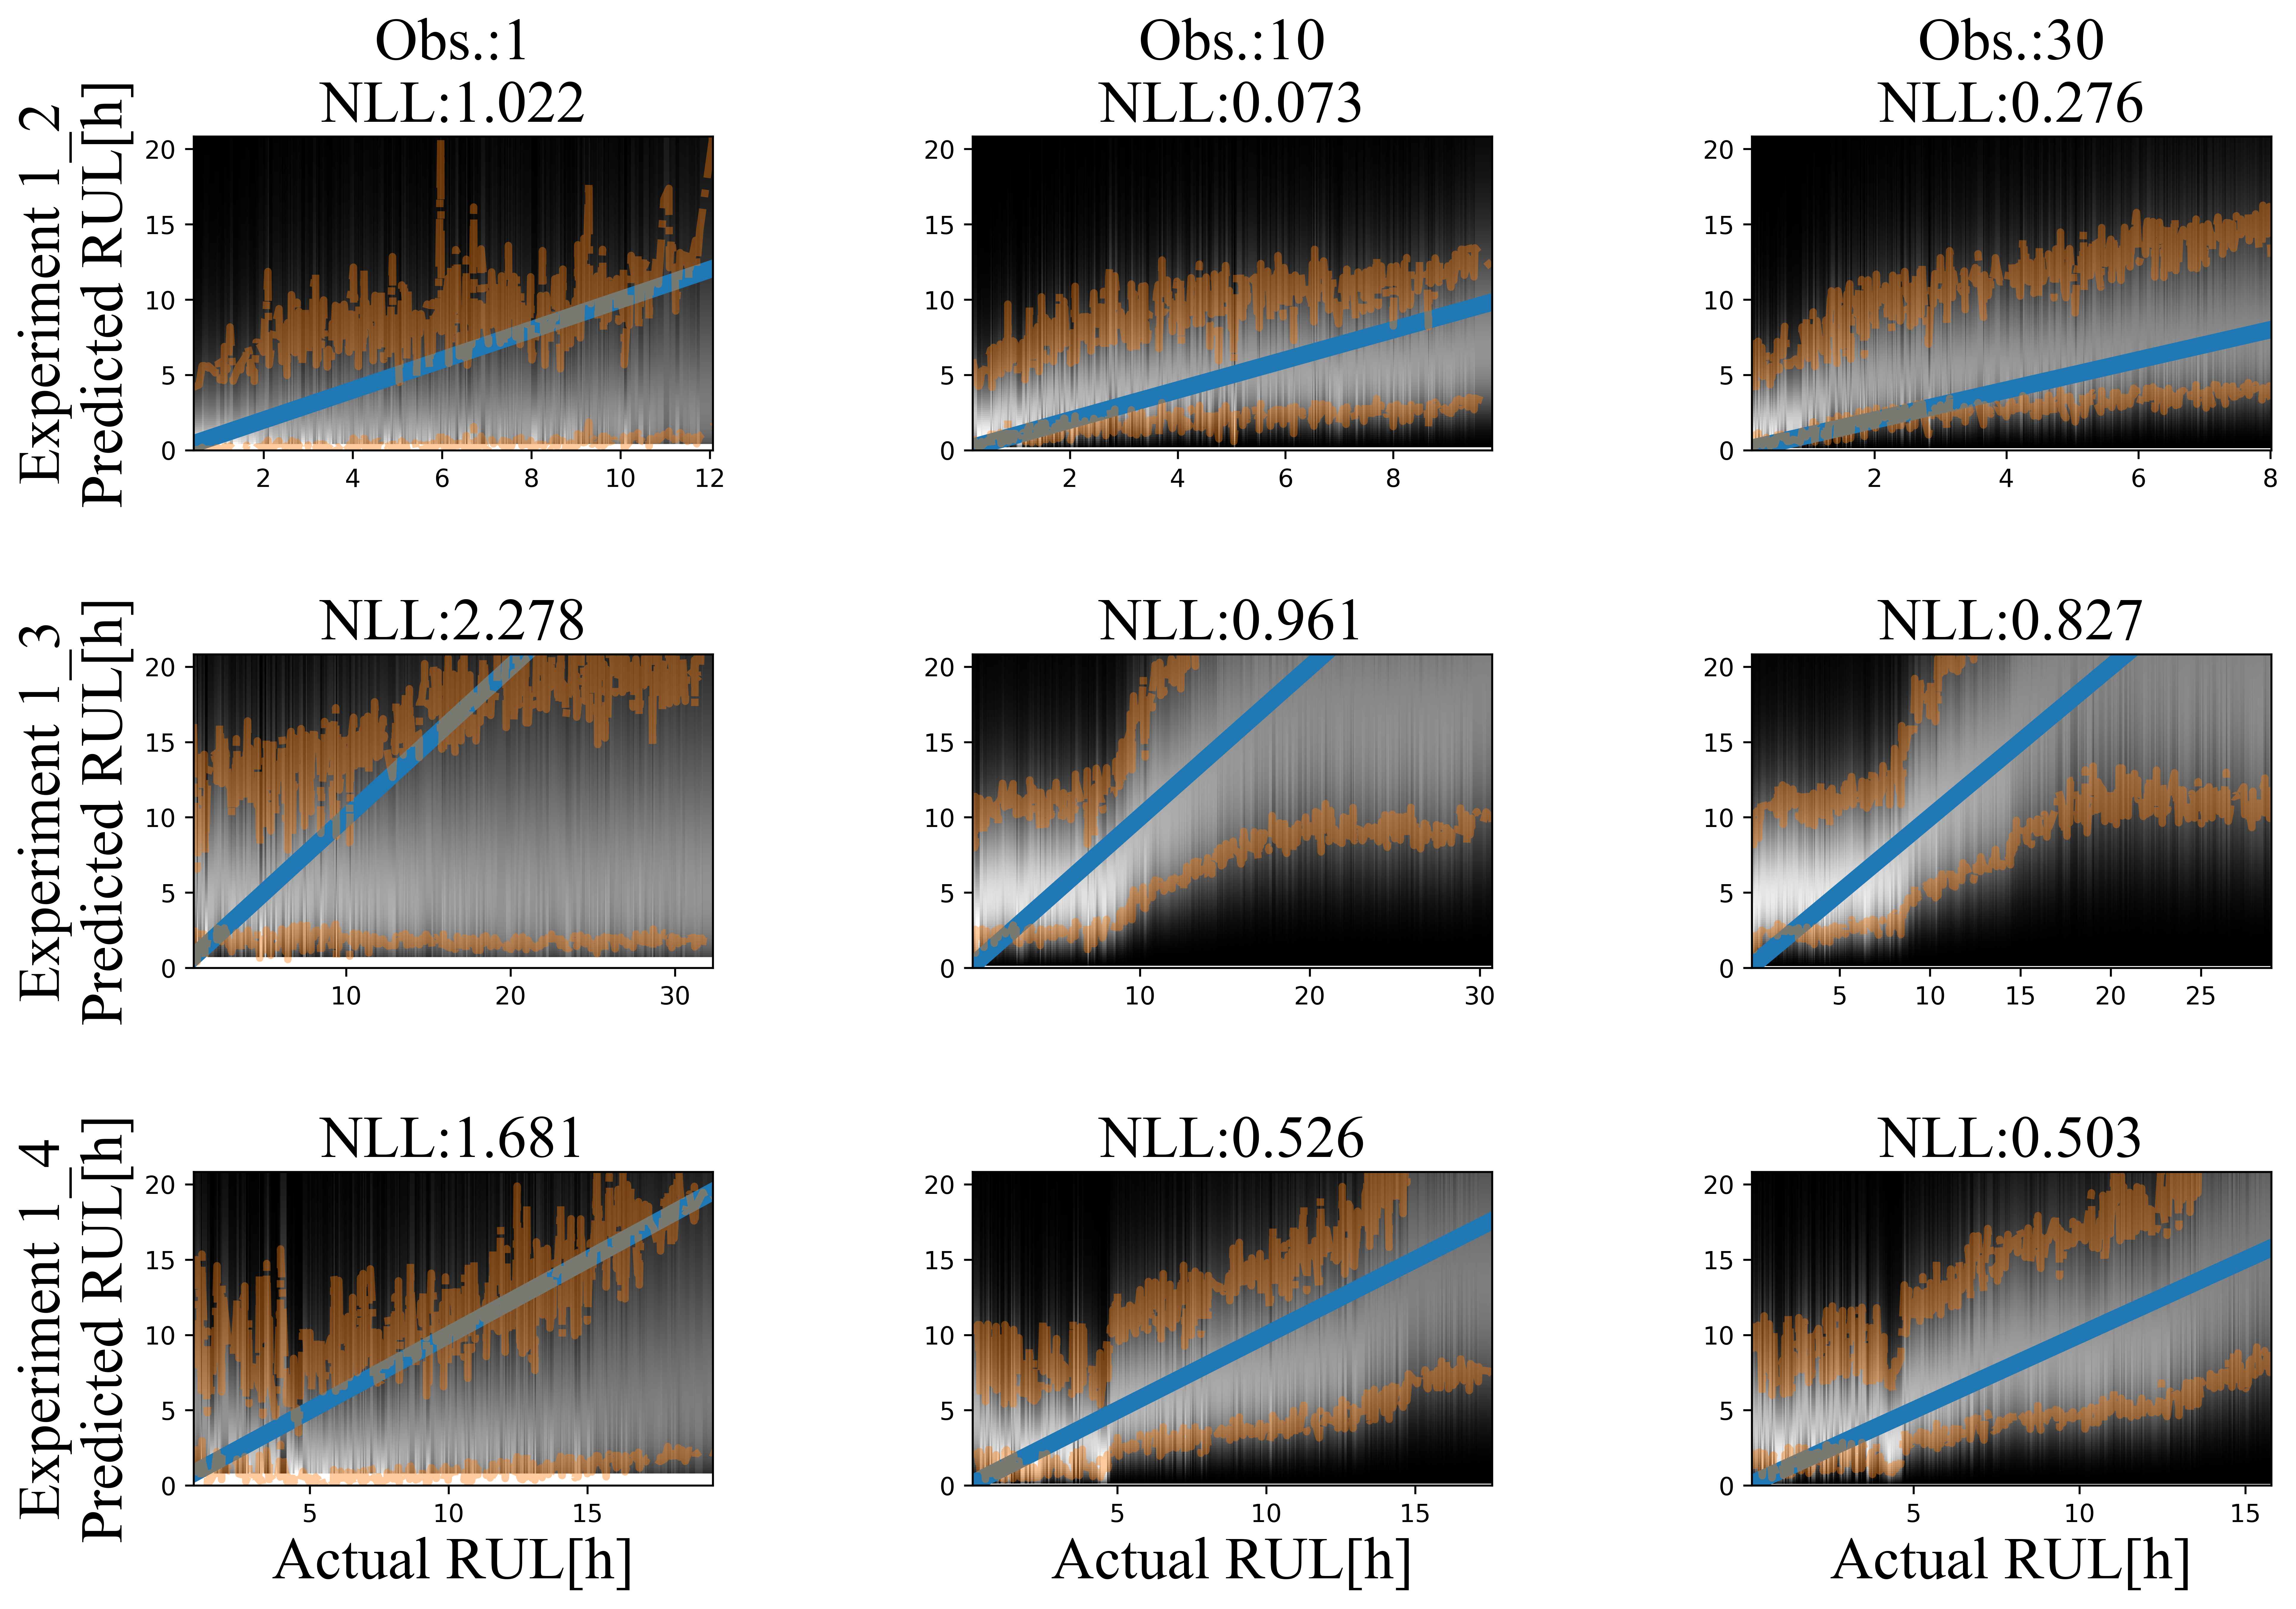

In [37]:
plot_experiments_rnn(DATASET.inds_exp_source[0:3])

# Some plots needed in some visualizations

### Gated RNN update:

\begin{align*} 
  c_{t} = & Sigmoid(g_h(x_t, h_{t-1})) \odot tanh(f_h(x_t, h_{t-1})) \\  &+ Sigmoid(g_f(x_t, h_{t-1})) \odot c_{t-1} 
 \end{align*}

In [60]:
g_h_input = np.random.randn(10,1)*100
g_f_input = np.random.randn(10,1)*100

r1 = np.random.randn(10,1)
r2 = np.random.randn(10,1)
r3 = np.random.randn(10,1)


g_h = sigmoid(g_h_input).T
pplot.axis("off")
pplot.imshow(g_h)
pplot.title("Update gate output@ t \n$Sigmoid(g_h(x_t, h_{t-1}))$", fontsize = 20)
pplot.show()

g_f = sigmoid(g_f_input).T
pplot.axis("off")
pplot.imshow(g_f>0.5)
pplot.title("Forget gate output@ t \n$Sigmoid(g_f(x_t, h_{t-1})$",fontsize = 20)
pplot.show()

c_tm1 = tanh(r1).T
pplot.axis("off")
pplot.imshow(c_tm1)
pplot.title("Previous memory state@ t-1 \n $ c_{t-1} $",fontsize = 20)
pplot.show()

gate_t_val = tanh(x_in_t)


h_tm1 = tanh(r2).T
pplot.axis("off")
pplot.imshow(h_tm1)
pplot.title("State update vector @ t \n $ tanh(f_h(x_t, h_{t-1})) $",fontsize = 20)
pplot.show()


h_tm1 = tanh(r3).T
pplot.axis("off")
pplot.imshow(h_tm1 * g_h + c_tm1 * g_f)
pplot.title("New memory state @ t ",fontsize = 20)
pplot.show()



NameError: name 'sigmoid' is not defined